# Context
This notebook drives the training process for different models.

In [1]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [2]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup



Chosen class grouping: all-classes


Directory /Users/diego/Desktop/iteso/TOG/ exists. Continuing with execution
Directory /Users/diego/Desktop/iteso/TOG/data exists. Continuing with execution
Directory /Users/diego/Desktop/iteso/TOG/src exists. Continuing with execution
Directory /Users/diego/Desktop/iteso/TOG/bin exists. Continuing with execution
Directory /Users/diego/Desktop/iteso/TOG/media exists. Continuing with execution
Directory /Users/diego/Desktop/iteso/TOG/scores exists. Continuing with execution


In [3]:
TRAIN_classes = 'two-classes'
score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_KNN_CODE, "2025-06-13_11:22:09.csv")
top_barrier=5

# Score analysis

## Helper functions

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [5]:
def visualize(df, group_cols, top, filter_cols=None, filter_values=None):
    """
    Optionally filters df by filter_cols == filter_values, groups by group_cols,
    selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
    """
    filter_desc = ""

    # Filter if needed
    if filter_cols and filter_values:
        for col, val in zip(filter_cols, filter_values):
            df = df[df[col] == val]
        filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

    # Group, take top `top` by accuracy, compute mean
    mean_accuracies = (
        df.groupby(group_cols)
          .apply(lambda g: g.sort_values('accuracy', ascending=False).head(top)['accuracy'].mean())
          .reset_index(name='mean_accuracy')
    )

    # Create simple string labels for the x-axis
    mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

    # Plot
    colors = sns.color_palette("muted", len(mean_accuracies))
    plt.figure(figsize=(10, 6))
    plt.bar(mean_accuracies['label'], mean_accuracies['mean_accuracy'], color=colors)

    plt.ylabel(f"Mean Accuracy (Top {top})")
    plt.title(f"Top {top} Mean Accuracies per {' + '.join(group_cols)}{filter_desc}")
    plt.xticks(rotation=45, ha='right')

    # Set y-limits with padding
    min_val = mean_accuracies['mean_accuracy'].min()
    max_val = mean_accuracies['mean_accuracy'].max()
    padding = (max_val - min_val) * 0.3  # 10% padding
    plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

    # Add values on bars
    for i, val in enumerate(mean_accuracies['mean_accuracy']):
        plt.text(i, val + padding*0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


## Data

In [6]:
import pandas as pd

In [7]:
knn_scores_df = pd.read_csv(score_file)
knn_scores_df = knn_scores_df.fillna('None')
knn_scores_df.sort_values(by="accuracy", ascending=False)

,class_list,accuracy,data_unit,PH2,PH3,reducer,kernel,n,k
2331,two-classes,0.994141,Spf,False,True,pca,None,11,1
2289,two-classes,0.994141,Spf,False,True,pca,None,10,1
2499,two-classes,0.994141,Spf,False,True,pca,None,15,1
2373,two-classes,0.994141,Spf,False,True,pca,None,12,1
2205,two-classes,0.994141,Spf,False,True,pca,None,8,1
...,...,...,...,...,...,...,...,...,...
3373,two-classes,0.441860,Spv,False,True,kpca,rbf,5,7
3788,two-classes,0.441860,Spv,False,True,kpca,rbf,15,2
2617,two-classes,0.418605,Spv,True,True,kpca,sigmoid,2,7
3790,two-classes,0.418605,Spv,False,True,kpca,rbf,15,4


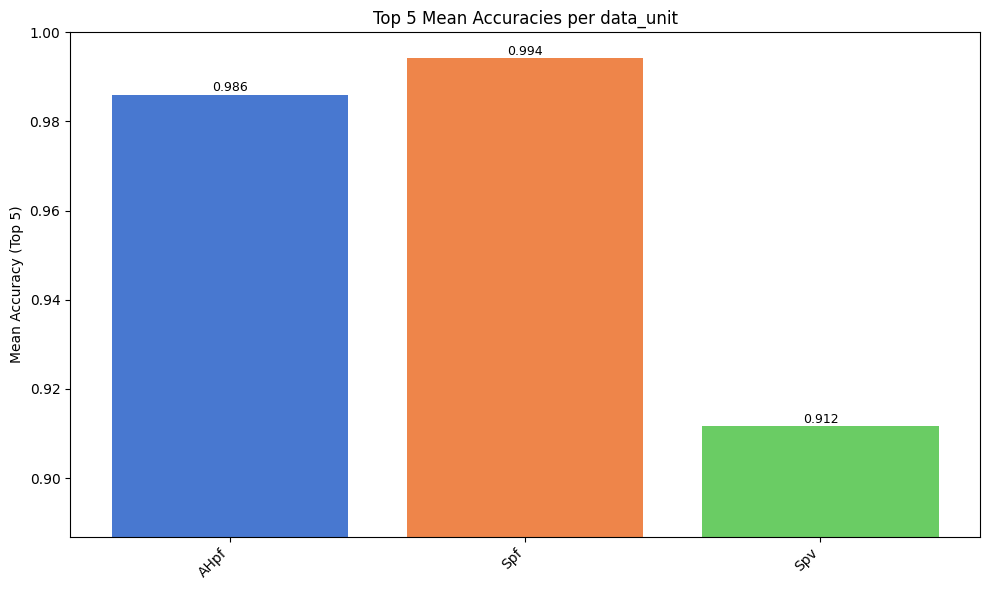

In [8]:
visualize(knn_scores_df, group_cols=['data_unit'], top=top_barrier)

### By data unit

#### Ahpf

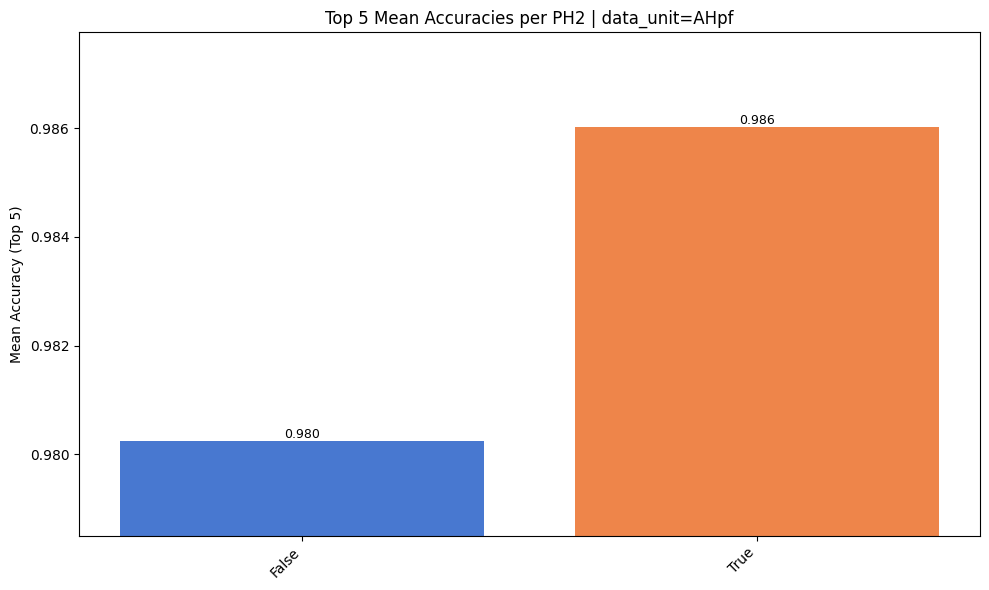

In [9]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

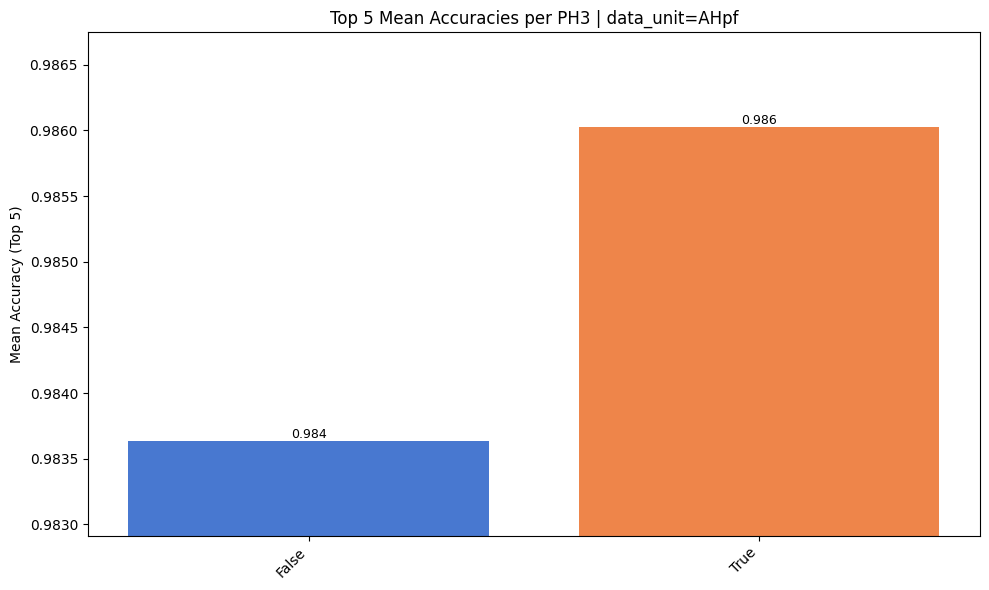

In [10]:
visualize(knn_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

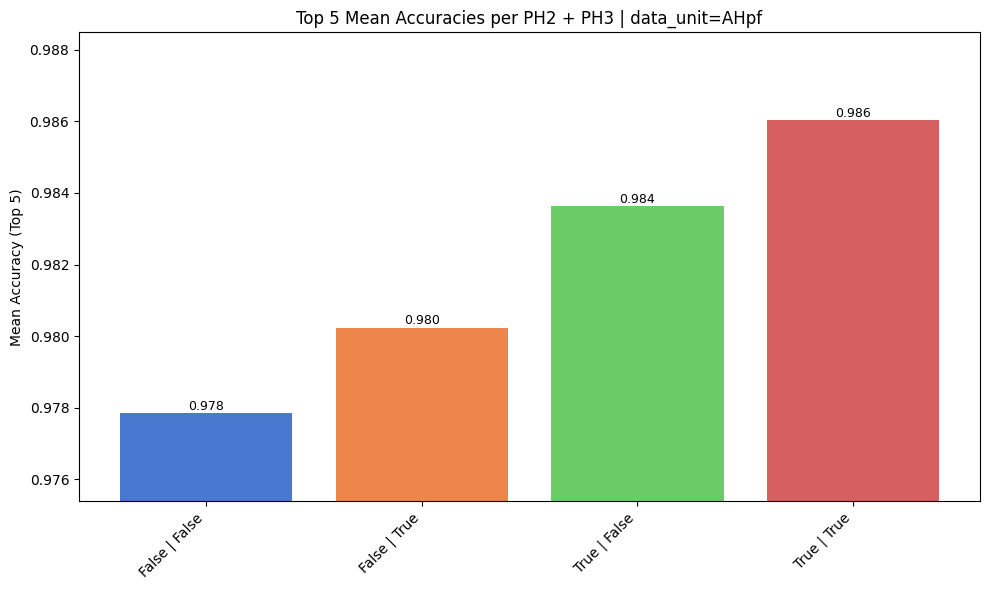

In [11]:
visualize(knn_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

#### Spf

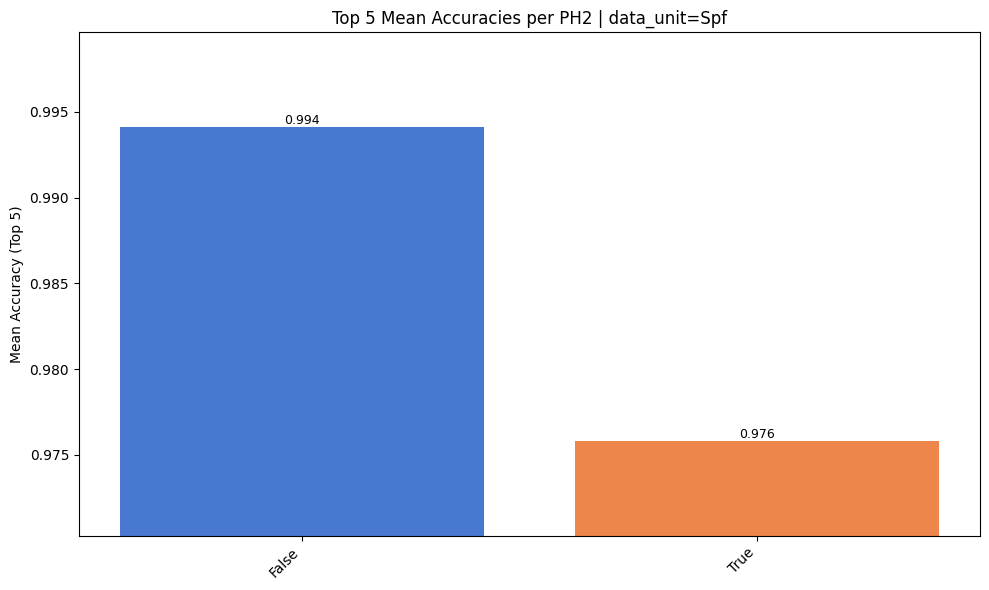

In [12]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

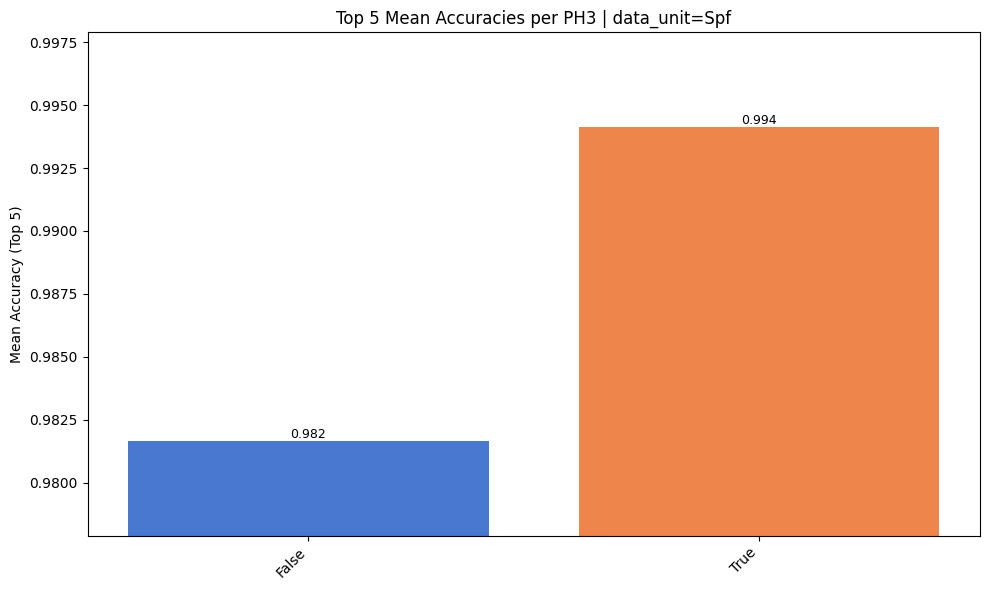

In [13]:
visualize(knn_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

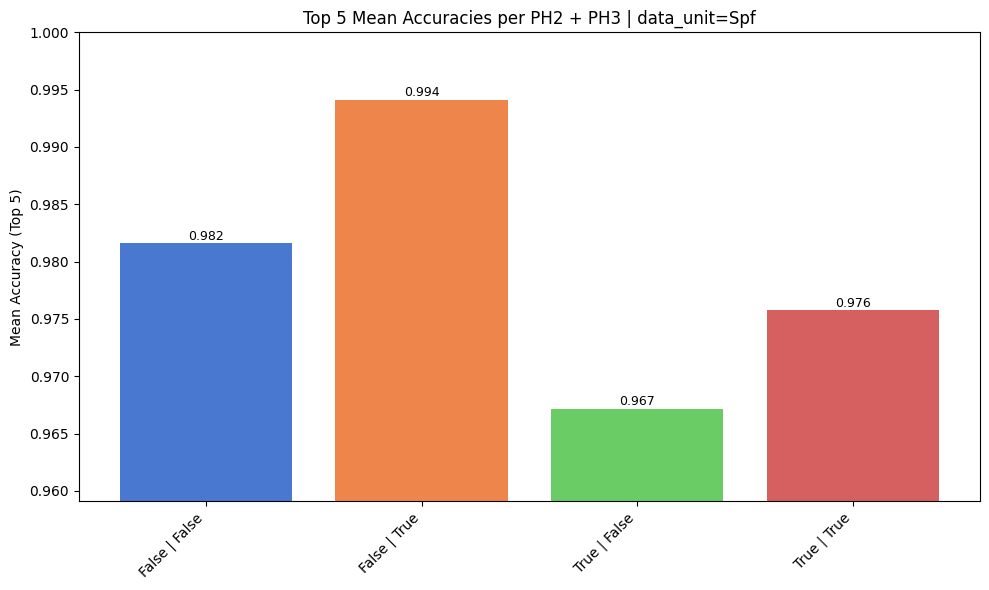

In [14]:
visualize(knn_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

#### Spv

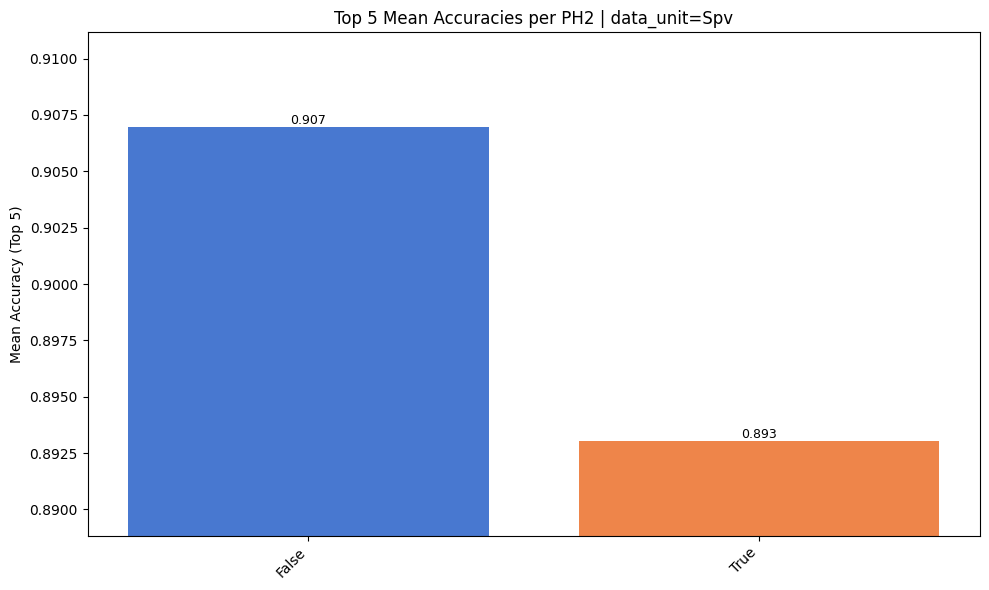

In [15]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

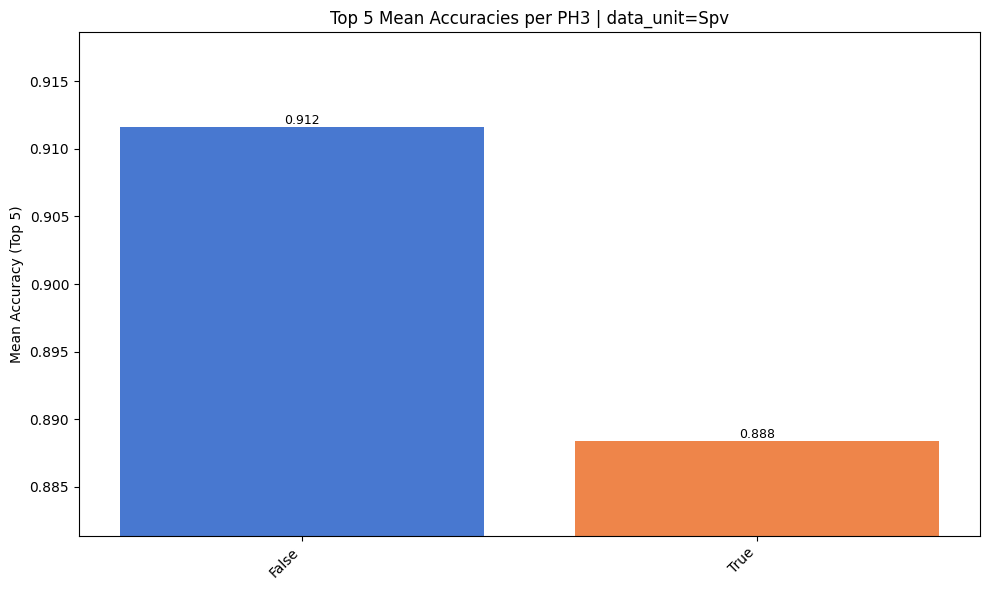

In [16]:
visualize(knn_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

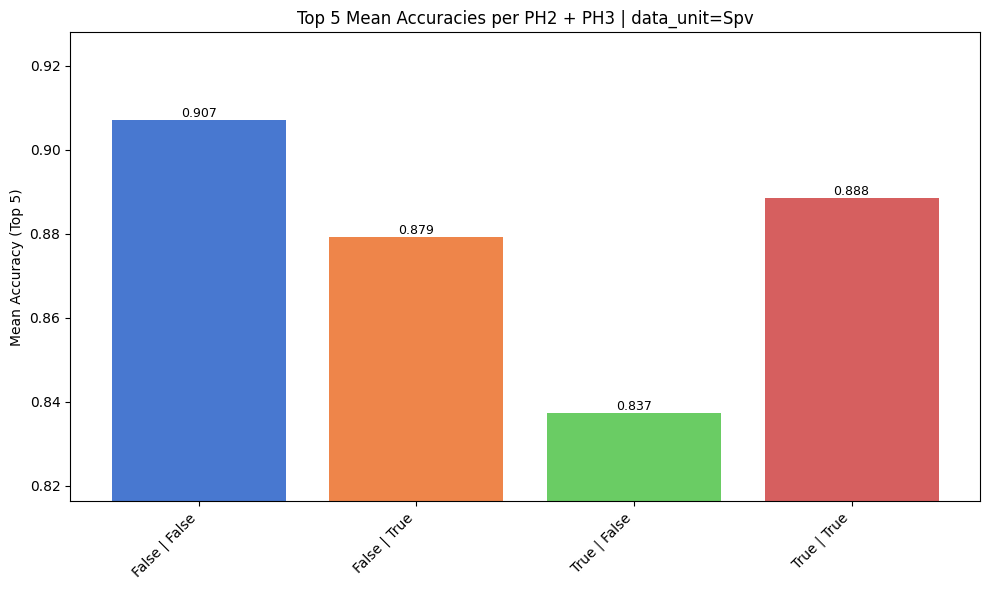

In [17]:
visualize(knn_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By reducer

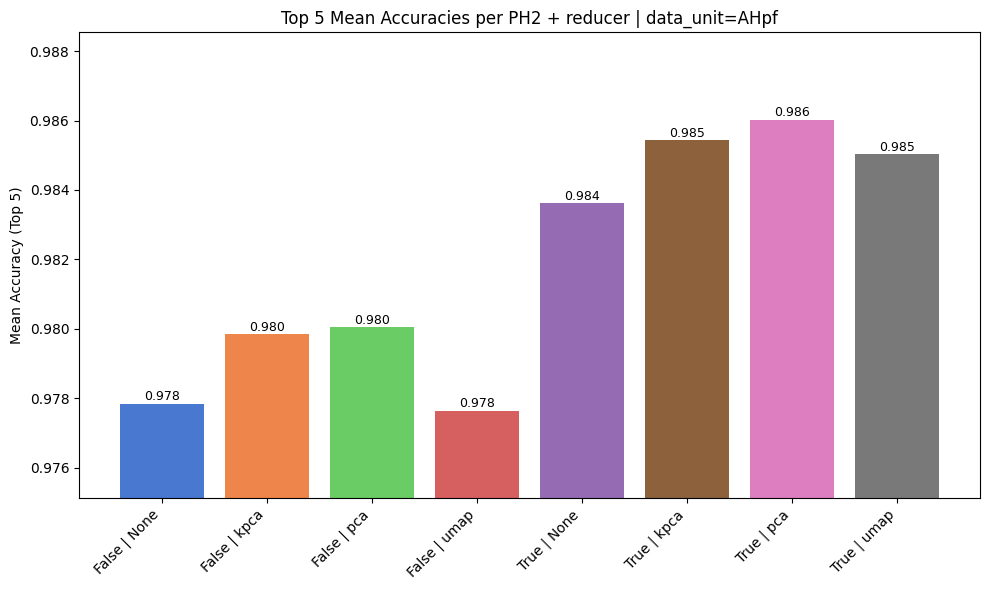

In [18]:
visualize(knn_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

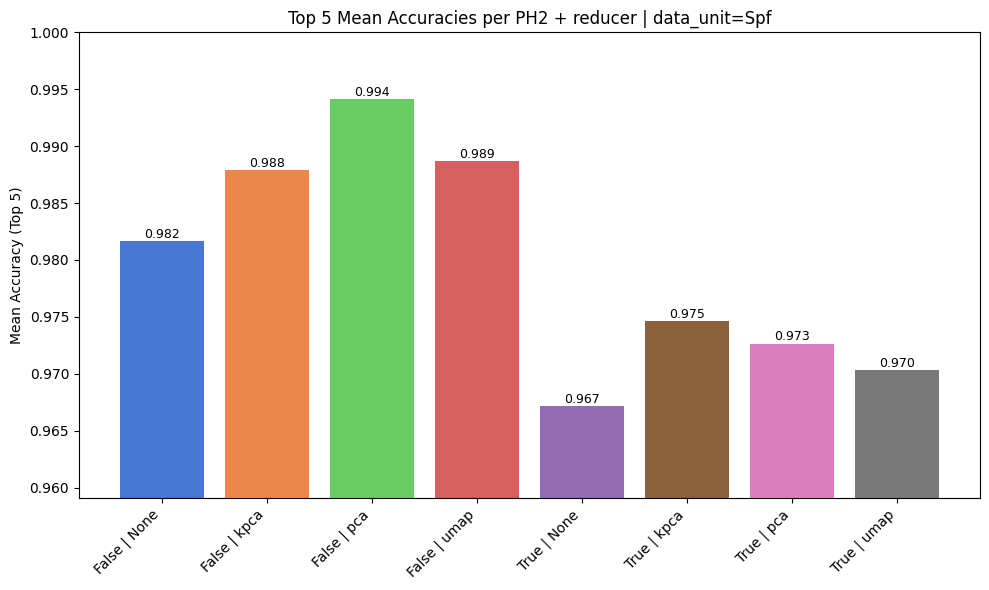

In [19]:
visualize(knn_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

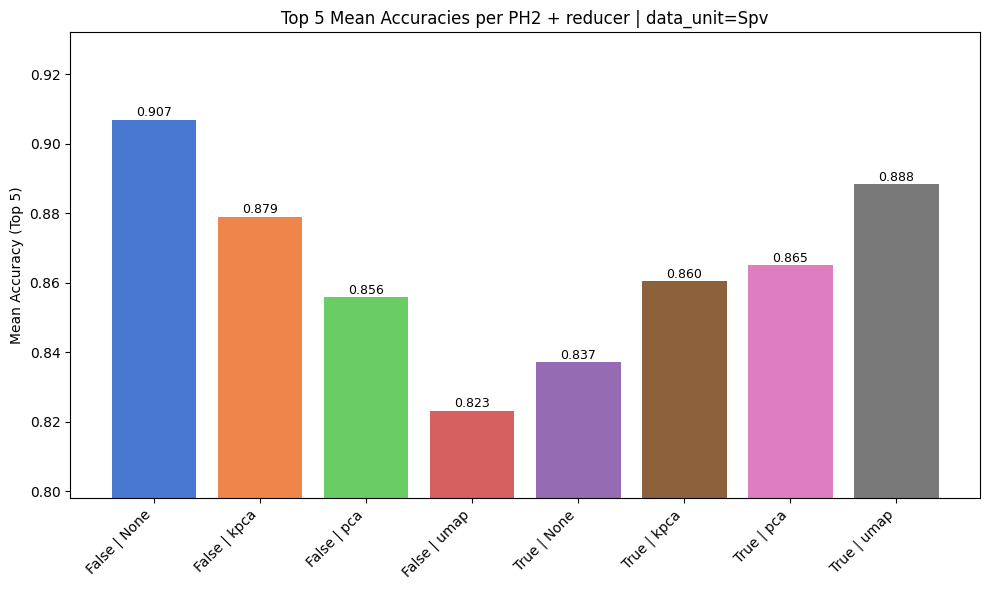

In [20]:
visualize(knn_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By kernel

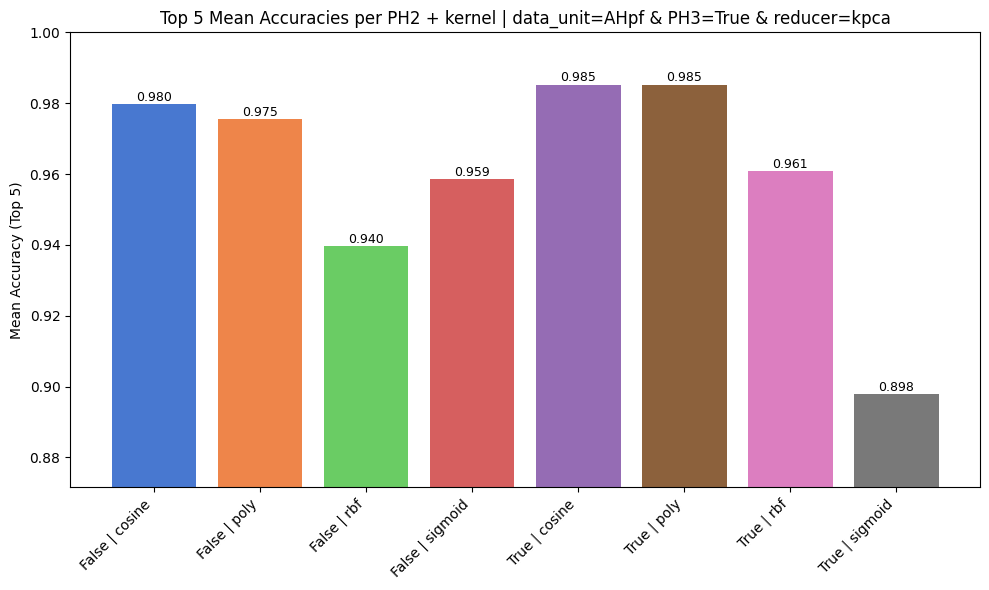

In [21]:
visualize(knn_scores_df, group_cols=['PH2', 'kernel'], top=top_barrier, filter_cols=['data_unit', 'PH3', 'reducer'], filter_values=[sup.DATA_AH_PF, True, 'kpca'])

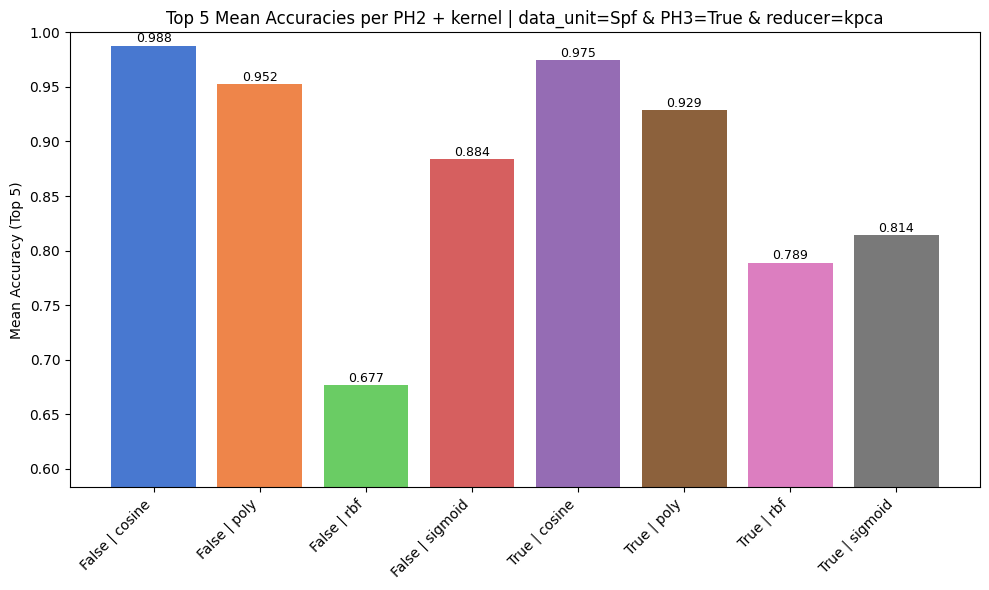

In [22]:
visualize(knn_scores_df, group_cols=['PH2', 'kernel'], top=top_barrier, filter_cols=['data_unit', 'PH3', 'reducer'], filter_values=[sup.DATA_S_PF, True, 'kpca'])

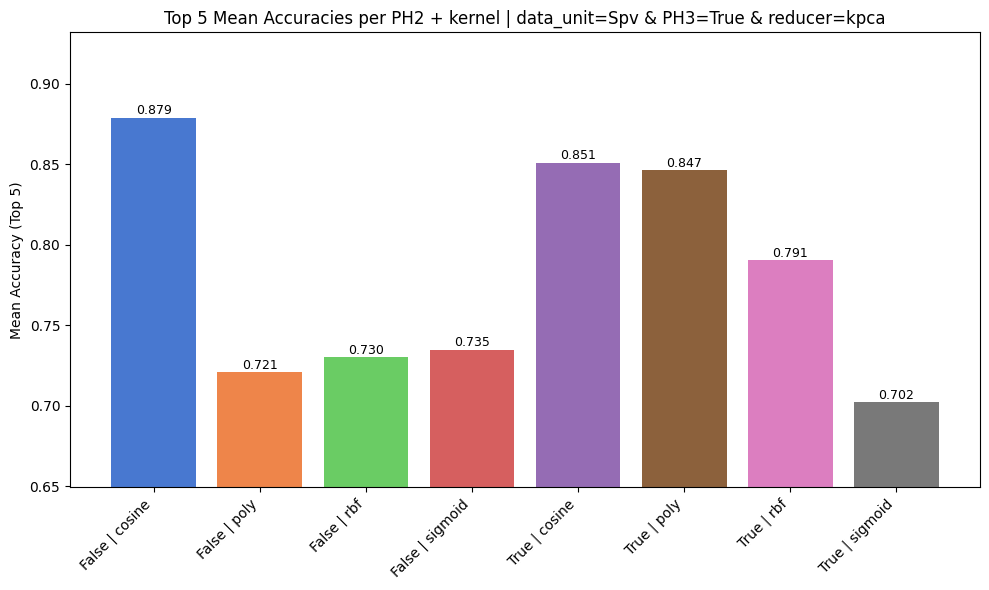

In [23]:
visualize(knn_scores_df, group_cols=['PH2', 'kernel'], top=top_barrier, filter_cols=['data_unit', 'PH3', 'reducer'], filter_values=[sup.DATA_S_PV, True, 'kpca'])

### By number of reduction components

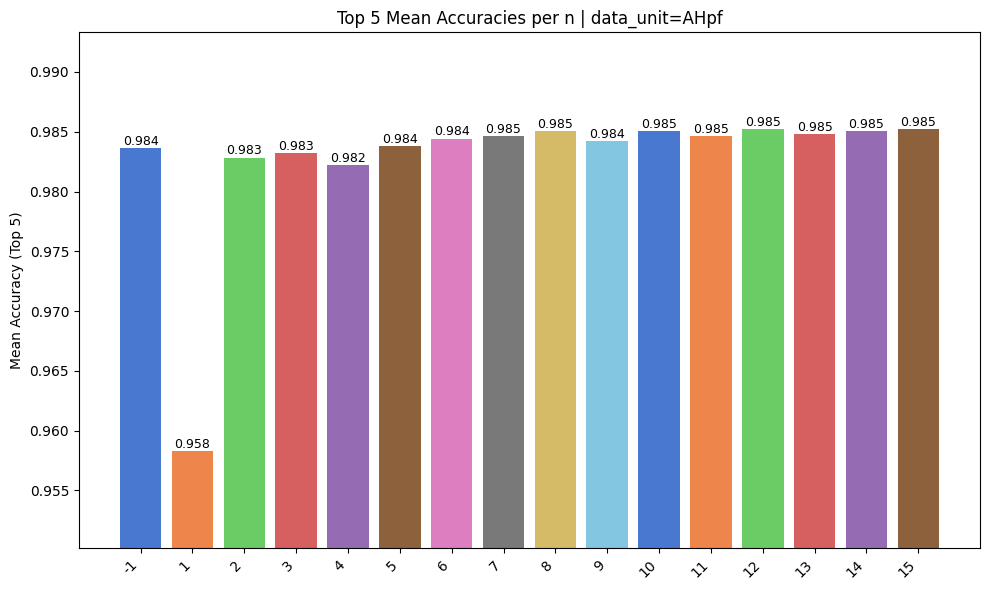

In [24]:
visualize(knn_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

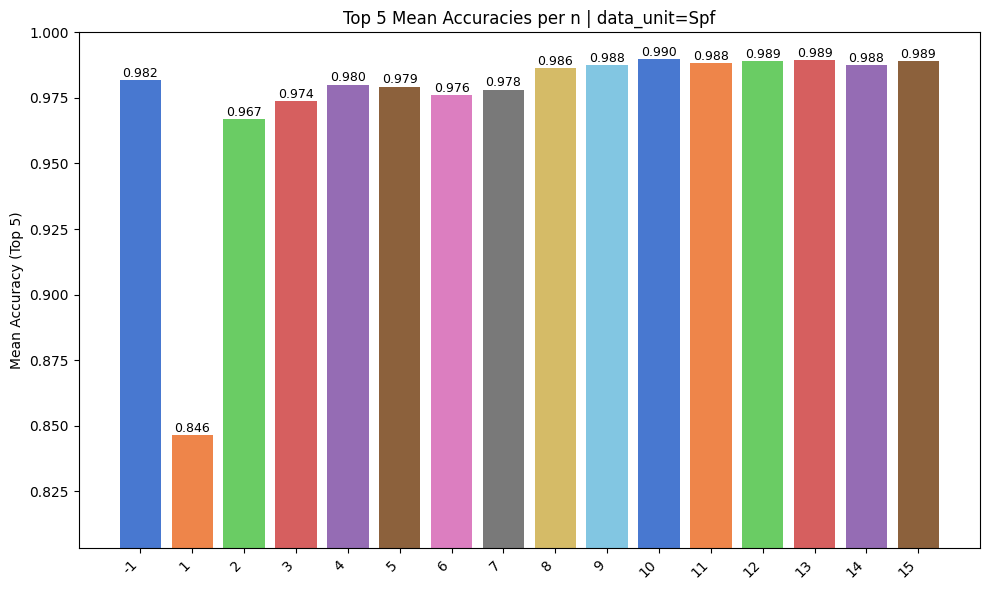

In [25]:
visualize(knn_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

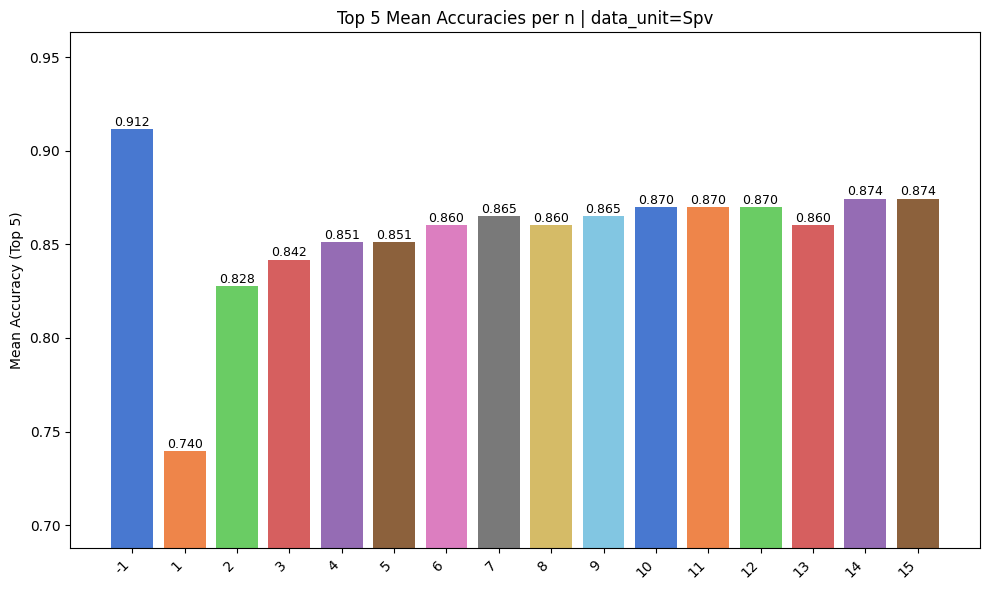

In [26]:
visualize(knn_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By number of neighbors

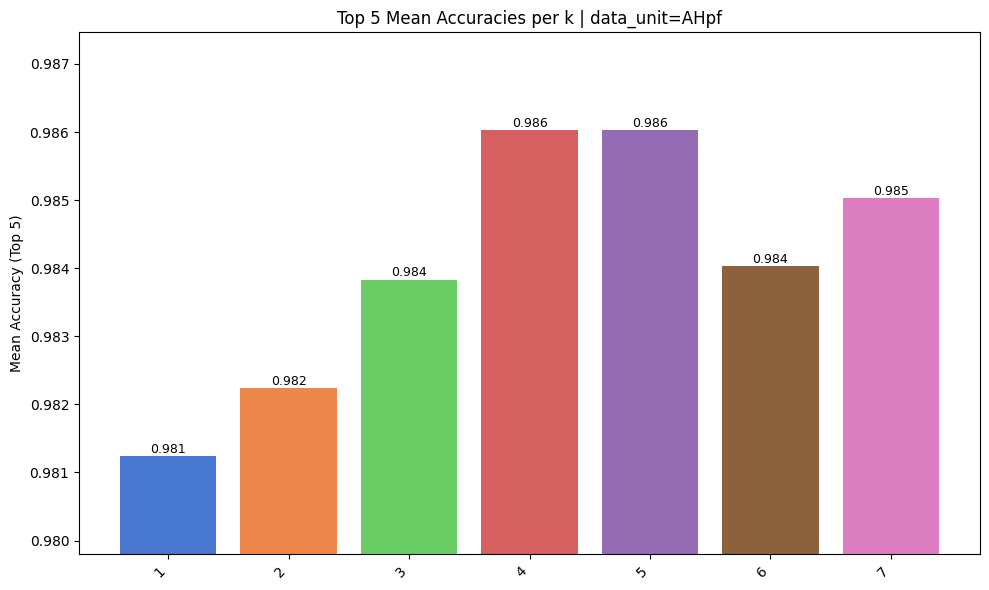

In [27]:
visualize(knn_scores_df, group_cols=['k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

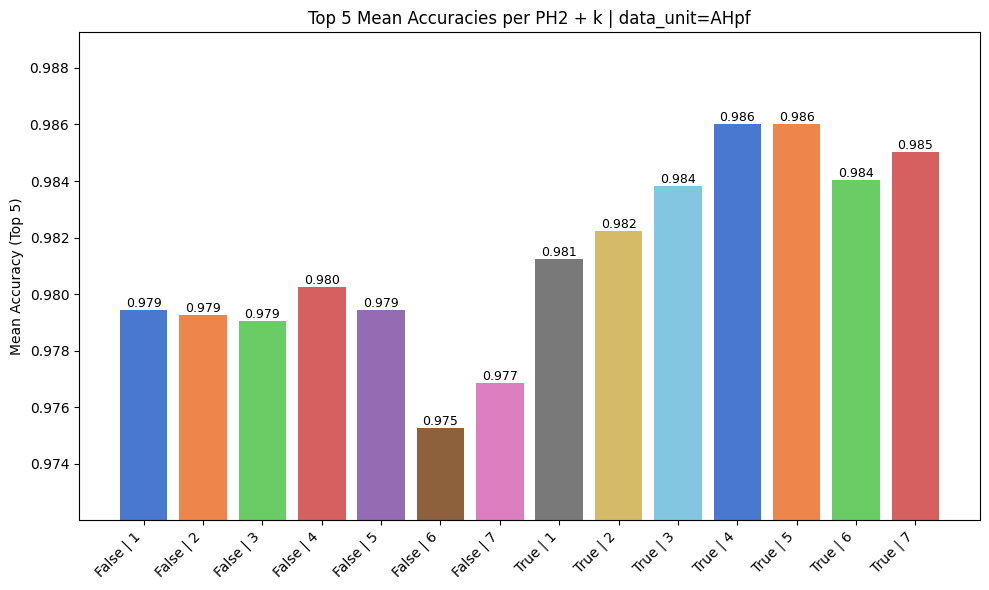

In [28]:
visualize(knn_scores_df, group_cols=['PH2', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

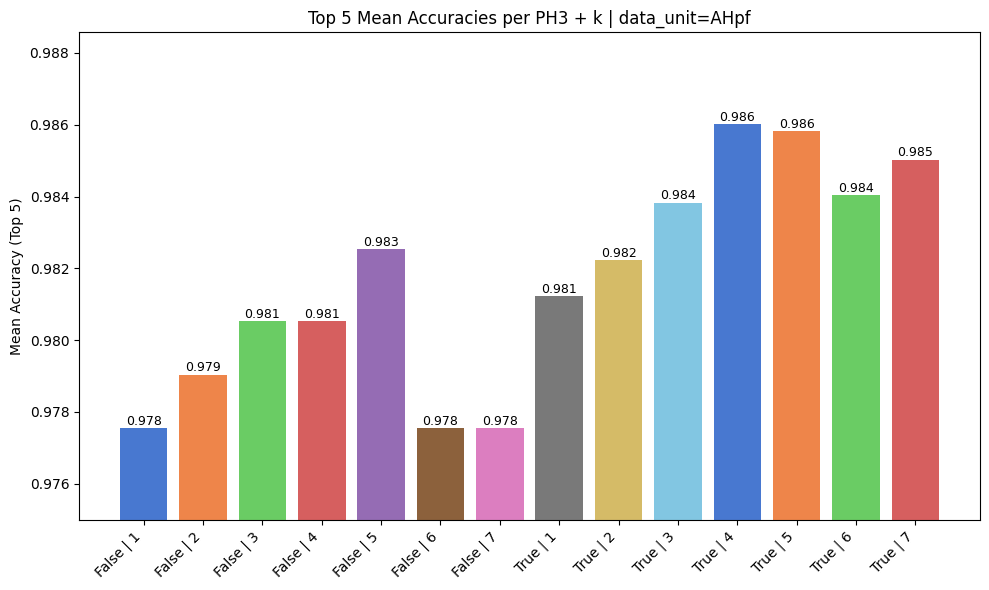

In [29]:
visualize(knn_scores_df, group_cols=['PH3', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

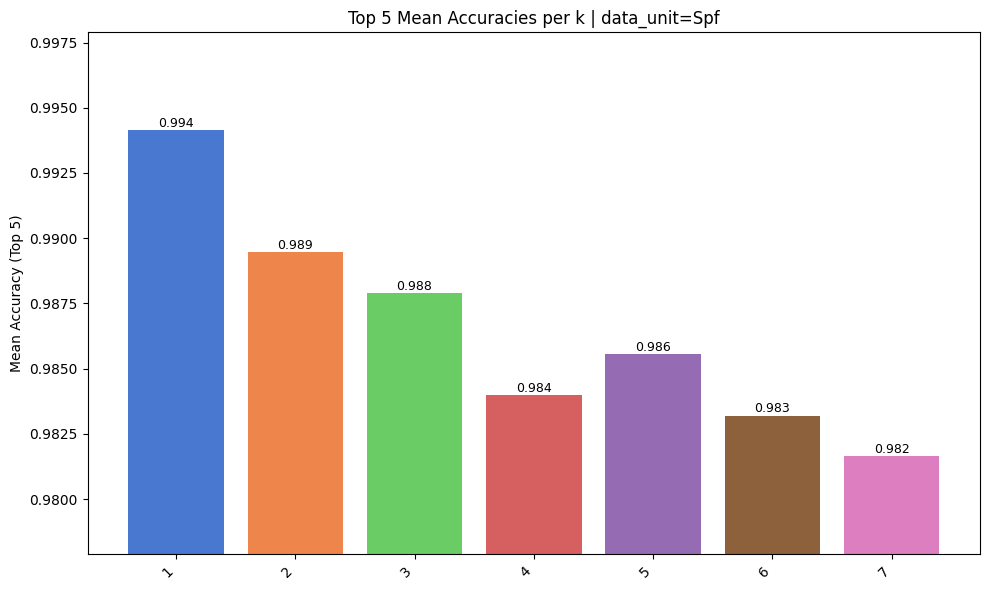

In [30]:
visualize(knn_scores_df, group_cols=['k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

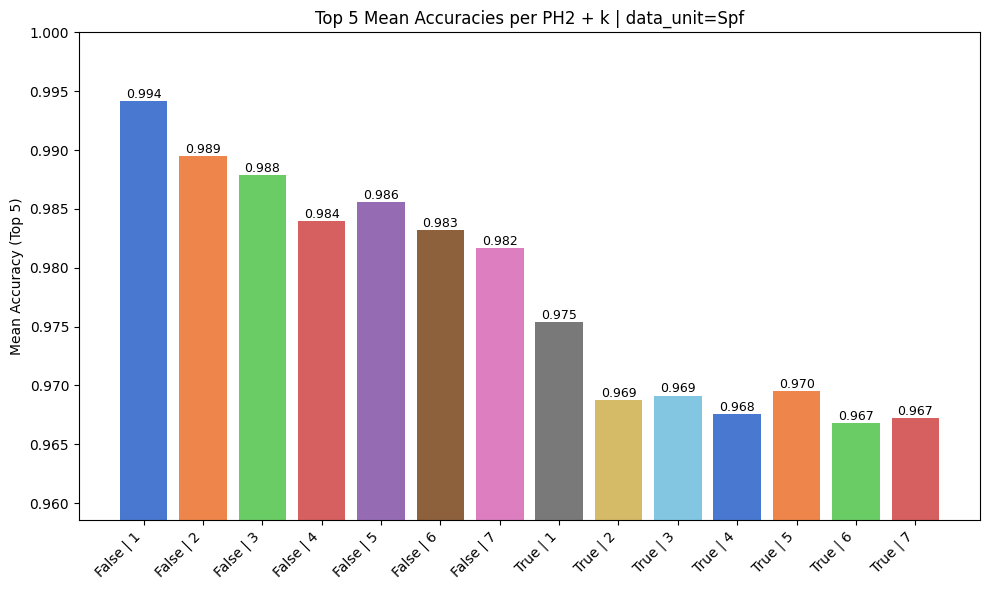

In [31]:
visualize(knn_scores_df, group_cols=['PH2', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

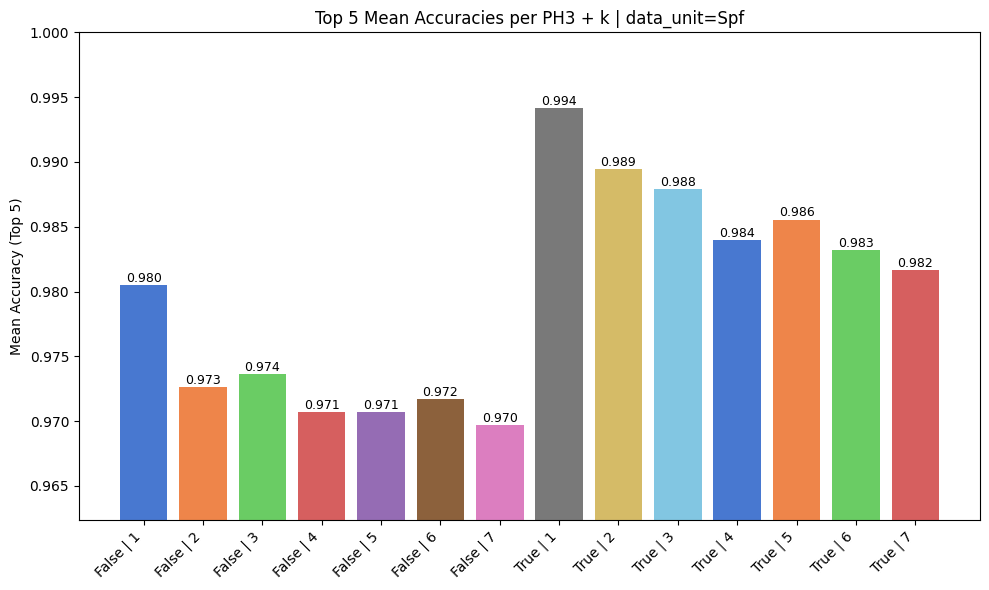

In [32]:
visualize(knn_scores_df, group_cols=['PH3', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

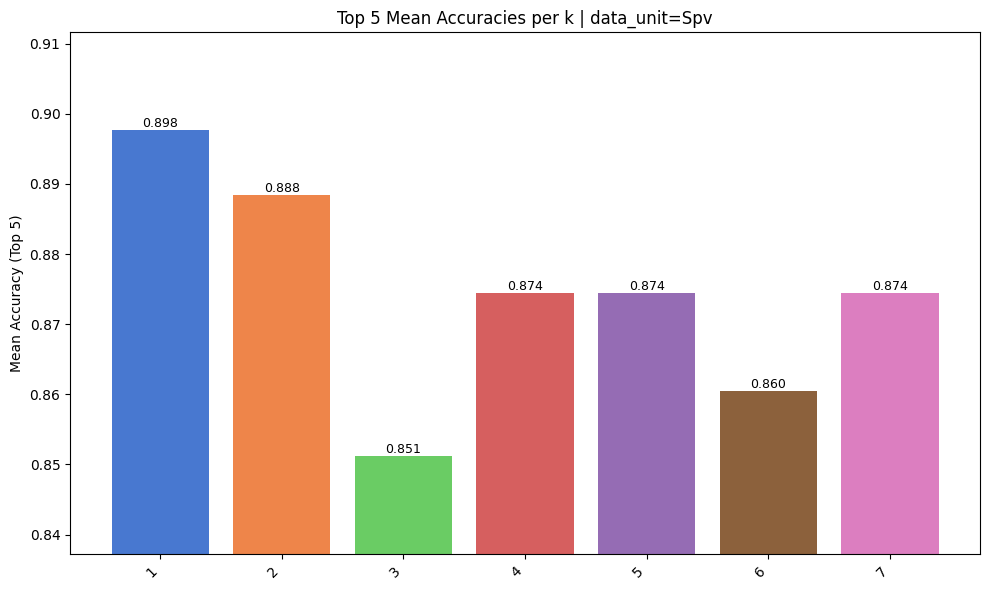

In [33]:
visualize(knn_scores_df, group_cols=[ 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

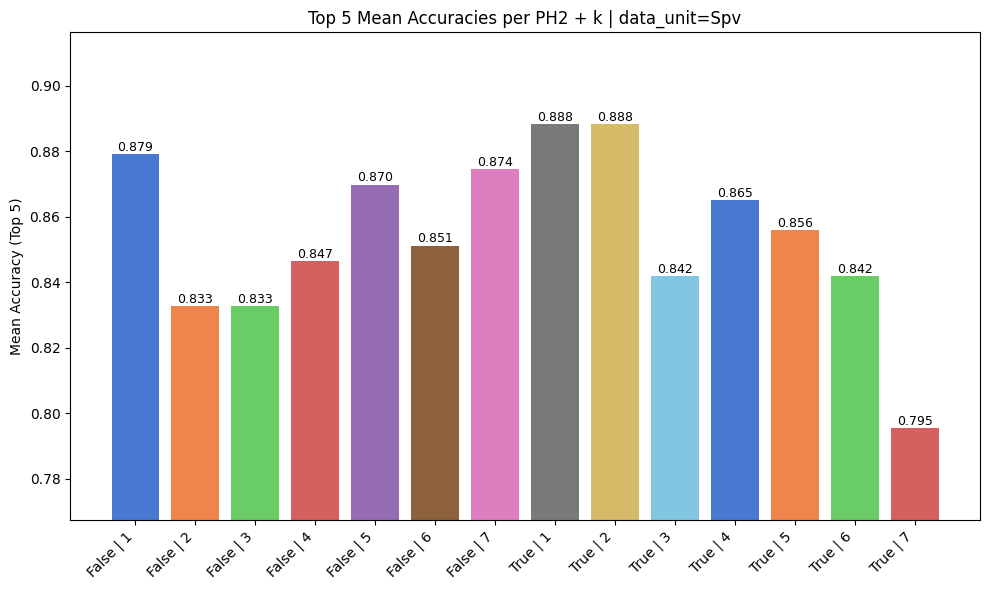

In [34]:
visualize(knn_scores_df, group_cols=['PH2', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

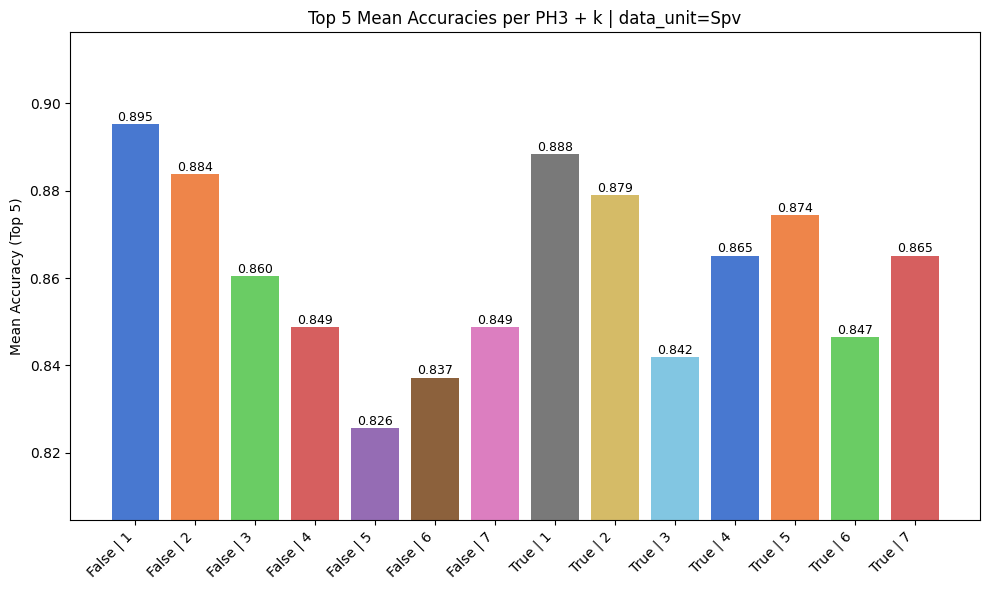

In [35]:
visualize(knn_scores_df, group_cols=['PH3', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])